In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import os
import re
import glob

from torchvision.transforms import Compose
from skimage.measure import block_reduce

import h5py
from tqdm import tqdm

from copy import deepcopy
import gc

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

# View cell dataset

33.025513 0.0 33.025513
(1024, 1024) (1024, 1024)


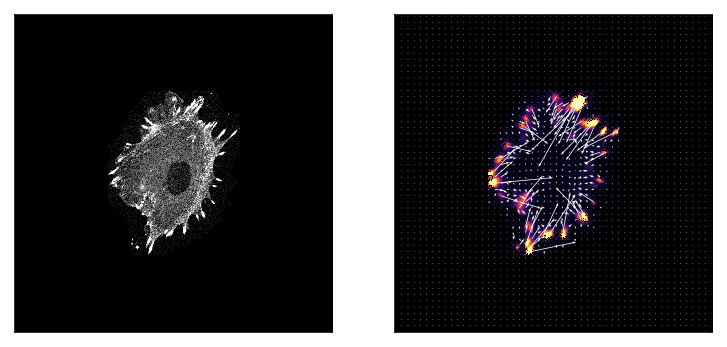

In [12]:
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.origin'] = 'lower'

i = 250
with h5py.File('data/cell_dataset.h5', 'r') as h5f:
    key = '11_cell_1/040'
    sample = {k: h5f[key][k] for k in h5f[key]}
    
    #Remove force baseline
    sample['zyxin'] = sample['zyxin'][()]
    sample['F_ml'] = sample['F_ml'][()]
    sample['F_ml'][:, ~sample['mask'][0]] = 0.
    
    print(np.ptp(sample['zyxin']), 
          np.min(sample['zyxin']), 
          np.max(sample['zyxin']))

    fig, ax = plt.subplots(1, 2, dpi=150)
    ax[0].imshow(sample['zyxin'][0], cmap='Greys_r', vmax=3)
    ax[1].imshow(np.linalg.norm(sample['F_ml'], axis=0), cmap='inferno', vmax=3)
    
    Y, X = np.mgrid[:sample['F_ml'].shape[-2], :sample['F_ml'].shape[-1]]
    print(Y.shape, X.shape)
    skip = 20
    
    ax[1].quiver(X[::skip, ::skip], 
                 Y[::skip, ::skip],
                 sample['F_ml'][0, ::skip, ::skip], 
                 sample['F_ml'][1, ::skip, ::skip], 
                 scale=2e1,
                 color='white')
    
for a in ax:
    a.set(xticks=[], yticks=[])

# Testing models

Model loss:  0.02435585098961989
$\phi$ 3
$\xi$ 8
$\chi$ 35


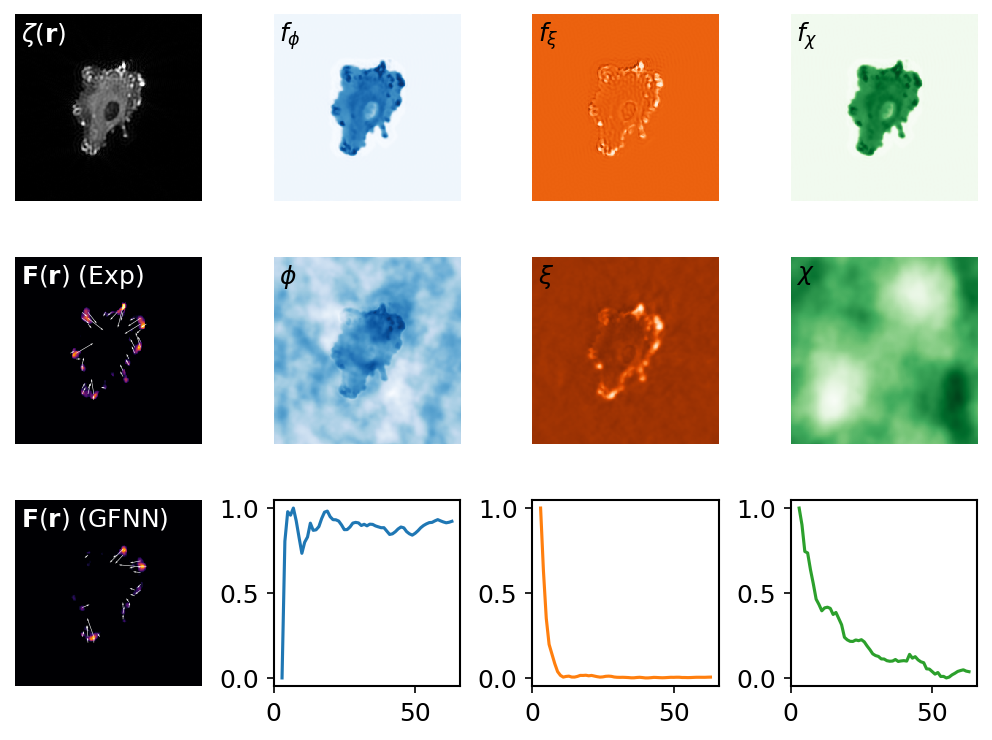

In [2]:
import matplotlib.pyplot as plt
import matplotlib

labels = [
    '$\\phi$',
    '$\\xi$',
    '$\\chi$',
]

colors = ['tab:blue', 'tab:orange', 'tab:green']

def smooth(x, window=25):
    return np.convolve(x, np.ones(window) / window, mode='valid')

def rescale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def make_vector_field(v, downsample=8, threshold=0.3):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

def fields_plot(model, x, y0, mask):
    fig, ax = plt.subplots(3, 4, figsize=(6.5, 5), dpi=150, constrained_layout=True)
    f = model.conv_in(x[None])[0].numpy()
    
    plt.cm.Blues.set_bad('white')
    plt.cm.Blues_r.set_bad('white')

    plt.cm.Oranges.set_bad('white')
    plt.cm.Oranges_r.set_bad('white')

    plt.cm.Greens.set_bad('white')
    plt.cm.Greens_r.set_bad('white')
    
    F = f.copy()
    F[:, ~mask] = 10
    
    ax[0, 1].imshow(F[0], cmap='Blues')
    ax[0, 2].imshow(F[1], cmap='Oranges')
    ax[0, 3].imshow(F[2], cmap='Greens')
    
    if isinstance(model, RealGFNN):
        _, h, w = f.shape
        pad_size = [h+model.pad, w+model.pad]
        xq = np.fft.rfft2(f, s=pad_size)
        xq *= model.get_kernel().numpy()
        
        grad_phi = np.fft.irfft2(mtwopii * model.q * xq[0:1], s=pad_size)
        grad_chi = np.fft.irfft2(mtwopii * model.q * xq[2:3], s=pad_size)
        phi = np.fft.irfft2(xq[0:1], s=pad_size)
        psi = np.fft.irfft2(xq[1:2], s=pad_size)
        chi = np.fft.irfft2(xq[2:3], s=pad_size)
        
    else:
        xq = np.fft.fft2(f)
        xq = xq * model.get_kernel().numpy()

        grad_phi = np.fft.ifft2(mtwopii * model.q * xq[0:1]).real
        grad_chi = np.fft.ifft2(mtwopii * model.q * xq[2:3]).real

        phi = np.fft.ifft2(xq[0:1]).real
        psi = np.fft.ifft2(xq[1:2]).real
        chi = np.fft.ifft2(xq[2:3]).real
    
    y = grad_phi + psi * grad_chi
    y0 = y0.cpu()
            
    ax[0, 0].imshow(np.linalg.norm(x, axis=0), cmap='Greys_r', vmin=0, vmax=3)
    ax[1, 0].imshow(np.linalg.norm(y0, axis=0), cmap='inferno', vmin=0.5, vmax=4)
    ax[2, 0].imshow(np.linalg.norm(y, axis=0), cmap='inferno', vmin=0.5, vmax=4)
    qwargs = {'color': 'w', 'width': 0.003, 'scale': 2e1}
    threshold=.4
    ax[1, 0].quiver(*make_vector_field(y0, threshold=threshold), **qwargs)
    ax[2, 0].quiver(*make_vector_field(y, threshold=threshold), **qwargs)
    
    phi[:, ~mask] = np.nan
    psi[:, ~mask] = np.nan
    chi[:, ~mask] = np.nan
    
    grad_phi[:, ~mask] = np.nan
    grad_chi[:, ~mask] = np.nan

    ax[1, 1].imshow(phi[0], cmap='Blues')
    ax[1, 2].imshow(psi[0], cmap='Oranges')
    ax[1, 3].imshow(chi[0], cmap='Greens')
    
    #ax[1, 3].quiver(grad_chi[0], grad_chi[1], color='black')
    skip=8
    grad_cy = np.gradient(chi[0], axis=-2)
    grad_cx = np.gradient(chi[0], axis=-1)
    #ax[1, 3].quiver(grad_cy[::skip, ::skip], grad_cx[::skip, ::skip], color='black')
        
    for a in ax.flatten()[:9]:
        a.set(xticks=[], yticks=[])
        a.axis('off')
    
    x0 = 0.03
    y0 = 0.97
    fig.text(x0, y0, '$\zeta(\mathbf{r})$', 
            ha='left', va='top',
            color='white', transform=ax[0, 0].transAxes)
    fig.text(x0, y0, '$\mathbf{F}(\mathbf{r})$ (Exp)', 
            ha='left', va='top',
            color='white', transform=ax[1, 0].transAxes)
    fig.text(x0, y0, '$\mathbf{F}(\mathbf{r})$ (GFNN)', 
            ha='left', va='top',
            color='white', transform=ax[2, 0].transAxes)
    
    fig.text(x0, y0, '$f_{\\phi}$', 
            ha='left', va='top',
            color='black', transform=ax[0, 1].transAxes)
    fig.text(x0, y0, '$\\phi$', 
            ha='left', va='top',
            color='black', transform=ax[1, 1].transAxes)
    
    fig.text(x0, y0, '$f_{\\xi}$', 
            ha='left', va='top',
            color='black', transform=ax[0, 2].transAxes)
    fig.text(x0, y0, '$\\xi$', 
            ha='left', va='top',
            color='black', transform=ax[1, 2].transAxes)  
    
    fig.text(x0, y0, '$f_{\\chi}$', 
            ha='left', va='top',
            color='black', transform=ax[0, 3].transAxes)
    fig.text(x0, y0, '$\\chi$', 
            ha='left', va='top',
            color='black', transform=ax[1, 3].transAxes)
    
    if isinstance(model, RealGFNN):
        size = model.size
        kernels = torch.fft.irfft2(model.get_kernel(), s=pad_size)
    else:
        size = model.size[0]
        kernels = torch.fft.ifft2(model.get_kernel()).real
    rmax = size // 4
    rgrid = torch.arange(size, device=kernels.device, dtype=kernels.dtype)
    rgrid = torch.fft.ifftshift(rgrid - (size // 2))
    rgrid = torch.linalg.norm(torch.stack(torch.meshgrid(rgrid, rgrid, indexing='ij')), dim=0).int()
    r = np.arange(3, rmax)
    for i in range(len(kernels)):
        kr = torch.empty(len(r), device=kernels.device, dtype=kernels.dtype)
        for j in range(len(r)):
            kr[j] = kernels[i][np.abs(rgrid - r[j]) < 1].mean()
        mask = ~torch.isnan(kr)
        rplot = r[mask.cpu().numpy()]
        Grplot = kr[mask].cpu().numpy()
        Grplot = rescale(smooth(Grplot, window=1))
        
        ax[2, i+1].plot(rplot[:Grplot.shape[0]], 
                        Grplot, 
                        color=colors[i], label=labels[i], 
                        linewidth=1.5)

        rval = 0.1
        ridx = np.argwhere(Grplot < rval)[0, 0]
        print(labels[i], rplot[ridx])
    
        ax[2,i+1].set_aspect(np.ptp(ax[2,i+1].get_xlim()) / np.ptp(ax[2,i+1].get_ylim()))
    
    return fig

fontsize = 12
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['axes.labelsize'] = fontsize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'None'

from gfnn_models import *
from gfnn_data_processing import *

version = 'RealGFNN'
beta=1e-1
down = 4

info = torch.load('UnseenWashout_RealGFNN_down=%d_beta=%g' % (down, beta), 
                  map_location='cpu')
gfnn_model = RealGFNN(**info['hparams'])
print('Model loss: ', info['loss'])
gfnn_transform = gfnn_model.get_transform(**info['hparams'])
gfnn_model.load_state_dict(info['state_dict'])
gfnn_model.eval();

dataset = Dataset(transform=gfnn_transform)
dataset.dataframe = dataset.dataframe[dataset.dataframe.cell == '11_cell_1'].reset_index(drop=True)

idx = 40
idx = 110
batch = dataset[idx]
x, y0 = batch
mask = x[0] != 0
with torch.no_grad():
    fig = fields_plot(gfnn_model, x, y0, mask)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset.transform = gfnn_model.get_transform(**info['hparams'])
gfnn_model.to(device)
gfnn_model.eval()
with torch.no_grad():
    Fml = []
    Fgf = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False, pin_memory=True)
    for batch in tqdm(loader):
        x, y0 = batch
        y = gfnn_model(x.to(device)).cpu()

        Fml.append(np.linalg.norm(y0, axis=-3).sum(axis=(-2, -1)))
        Fgf.append(np.linalg.norm(y, axis=-3).sum(axis=(-2, -1))) 

100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Radius = 5 um
Radius = 23 um
128 87.04


[[], [], None]

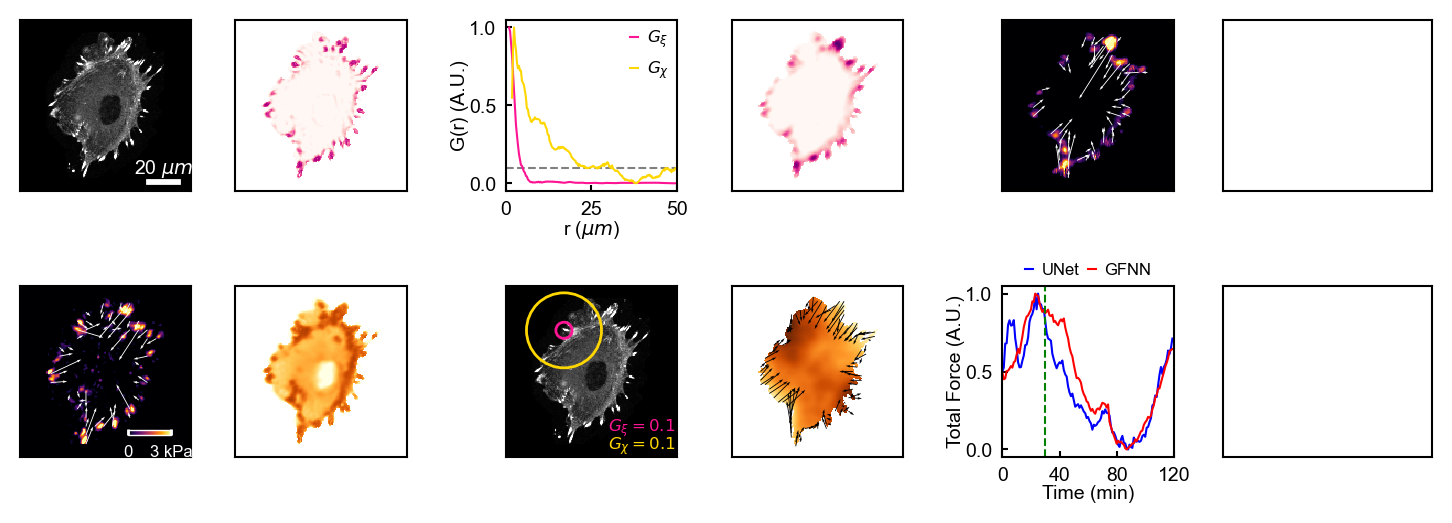

In [5]:
'''
SMALLER VERSION
'''
lw = .75
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size'] - 2
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = .5
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['legend.borderpad'] = 0.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'


from sklearn.preprocessing import MinMaxScaler


def smooth(x, window):
    return np.convolve(x, np.ones(window) / window, mode='valid')

def rescale(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def make_vector_field(v, downsample=8, threshold=0.3):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

def vector_plot(ax, y, scale=1):
    kwargs = {'origin': 'lower', 'cmap': 'inferno', 'vmin': 0.5, 'vmax': 3}
    qwargs = {'color': 'w', 'width': 0.005, 'scale': 1e1}
    threshold=.3
    ax.imshow(np.linalg.norm(y, axis=0), **kwargs)
    ax.quiver(*make_vector_field(y, threshold=threshold, downsample=8*scale), **qwargs)
    ax.set(xticks=[], yticks=[])

def sum_force_plot(ax_F, window=5):
    #Rescale predictions to [0, 1] range
    scaler = MinMaxScaler()
    unscaler = MinMaxScaler()
    window = 1
    
    smooth_Fml = scaler.fit_transform(smooth(np.concatenate(Fml, axis=0), window=window)[:, None])
    smooth_Fgf = scaler.fit_transform(smooth(np.concatenate(Fgf, axis=0), window=window)[:, None])
        
    t = np.arange(len(smooth_Fml))
    ax_F.plot(t, smooth_Fml, color='blue', label='UNet')
    ax_F.plot(t, smooth_Fgf, color='red', label='GFNN')
    ax_F.axvline(x=30, color='green', linestyle='--')
    ax_F.set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
    ax_F.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='Total Force (A.U.)')
    ax_F.legend(ncol=3, bbox_to_anchor=[0.5, 1], loc='lower center')
    ax_F.set_aspect(120 / 1.1)


def receptive_field(ax, center, G_r, color, rval=0.1, conversion=1):
        ridx = np.argwhere(G_r.G.values < rval)[0, 0]        
        rad = G_r.r.iloc[ridx]
        print('Radius = %.2g um' % (rad*conversion))
        c = plt.Circle(center, rad, edgecolor=color, fill=False)
        ax.add_patch(c)
    
def plot_greens_functions(ax, ax_G, gfnn_model, window=5, eps=0.25, down=4):
    '''
    Plot Green's functions
    '''
    conversion = down * 0.17
    with torch.no_grad():
        size = gfnn_model.size
        kernels = gfnn_model.get_kernel()
        kernels -= torch.mean(kernels, dim=(1, 2), keepdims=True) #Remove overall offset
        kernels = torch.fft.irfft2(kernels, s=(size, size))

        rmax = size // 2
        #rmax = 50 / conversion
        rgrid = torch.arange(size, device=kernels.device, dtype=kernels.dtype)
        rgrid = torch.fft.ifftshift(rgrid - (size // 2))
        rgrid = torch.linalg.norm(torch.stack(torch.meshgrid(rgrid, rgrid, indexing='ij')), dim=0)
        r = np.linspace(1, rmax, 300)
        for i in range(1, len(kernels)):
            kr = torch.empty(len(r), device=kernels.device, dtype=kernels.dtype)
            for j in range(len(r)):
                kr[j] = kernels[i][abs(rgrid - r[j]) < eps].mean()
            mask = ~torch.isnan(kr)
            rplot = smooth(r[mask.cpu().numpy()], window=window)
            Grplot = smooth(kr[mask].cpu().numpy(), window=window)
            Grplot = rescale(Grplot)
            
            if i == 2:
                rplot = rplot[3:]
                Grplot = Grplot[3:]
                Grplot = rescale(Grplot)

                        
            line, = ax_G.plot(rplot * conversion, Grplot, label=labels[i], color=colors[i])
            receptive_field(ax[1, 2], (210/down, 460/down), 
                            pd.DataFrame({'r': rplot, 'G': Grplot}), 
                            line.get_color(), 
                            rval=0.1,
                            conversion=conversion)

    print(rmax, rmax * conversion)
    rmax = rmax * conversion # change units to radians
    rmax = 50
    ax_G.set(xlim=[0, rmax], xticks=[0, rmax//2, rmax], xlabel='r ($\\mu m$)')
    ax_G.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='G(r) (A.U.)')
    ax_G.set_aspect(rmax / 1.1)
    ax_G.axhline(0.1, color='grey', linestyle='--', zorder=-1)
    ax_G.legend(loc='upper right')    

    
gfnn_model.to(torch.device('cpu'))
fig, ax = plt.subplots(2, 6, figsize=(7.2, 2.5), dpi=200, 
                       constrained_layout=True
                      )
labels = [
    '$G_{\\phi}$',
    '$G_{\\xi}$',
    '$G_{\\chi}$',
]
crop = 50
downsample=4
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['red', 'deeppink', 'gold']
ax_G = ax[0, 2]

tidx = 40

dataset.transform = gfnn_transform
img_batch = dataset[tidx]
numpy_transform = Compose(gfnn_transform.transforms[:3])
raw_transform = Compose(gfnn_transform.transforms[:2])


'''
Raw data plotting
'''

dataset.transform = numpy_transform
x = dataset[tidx]['zyxin'][0]
y0 = dataset[tidx]['F_exp']
kwargs = dict(origin='lower', cmap='Greys_r', vmin=0, vmax=4)

c = crop
ax[0, 0].imshow(x[c:-c, c:-c], **kwargs)
ax[0, 0].set(xticks=[], yticks=[])
ax[1, 2].imshow(x[c:-c, c:-c], **kwargs)
ax[1, 2].set(xticks=[], yticks=[])
vector_plot(ax[1, 0], y0[:, c:-c, c:-c])


'''
Plot GFNN predictions
'''
y = gfnn_model(img_batch[0][None])[0].detach()
vector_plot(ax[0, -2], y[:, crop:-crop, crop:-crop])
plot_greens_functions(ax, ax_G, gfnn_model, window=3)

    
'''
Plot Clebsch Parameters
'''
input_file = '/project/vitelli/cell_stress/TractionData_21_02_11/cell_1/Disp_Trac_CellMask_ForceMask_Actin_40.npy'
data = np.load(input_file)
mask = numpy_transform({
        'zyxin': data[-1, None],
        'mask': data[4, None],
        'F_ml': data[:2],
    })['mask'][0].astype(bool)
with torch.no_grad():
    x = gfnn_model.conv_in(img_batch[0][None])[0]
    
    _, h, w = x.shape
    s=[h, w]
    
    f_xi = x[1].numpy()
    f_chi = x[2].numpy()
    
    fft2, ifft2 = torch.fft.rfft2, torch.fft.irfft2
    
    xq = fft2(x, s=s)
    xq *= gfnn_model.kernel.exp()
    x = ifft2(xq, s=s)
    xi = ifft2(xq[1]).numpy().real
    chi = ifft2(xq[2]).numpy().real
    chi -= np.min(chi) #Shift because all that matters is the gradient

    grad_chi = ifft2(mtwopii * gfnn_model.q * xq[2:3], s=s).numpy()
    
    chi[~mask] = np.nan
    xi[~mask] = np.nan
    
    f_xi[~mask] = np.nan
    f_chi[~mask] = np.nan

xi_cmap = 'RdPu'
chi_cmap = 'YlOrBr'

std_fxi = np.abs(np.std(f_xi[mask]))
ax[0, 1].imshow(-f_xi[crop:-crop, crop:-crop], vmin=0.1*std_fxi, vmax=5*std_fxi, cmap=xi_cmap)
#Subtract min since we only need grad_chi
ax[1, 1].imshow(f_chi[crop:-crop, crop:-crop],  vmin=0., vmax=5*np.abs(np.std(f_chi[mask])), cmap=chi_cmap)
    
ax[0, 3].imshow(-xi[crop:-crop, crop:-crop], vmin=0.2, cmap=xi_cmap)
ax[1, 3].imshow(chi[crop:-crop, crop:-crop], cmap=chi_cmap)

grad_chi = -grad_chi[:, crop:-crop, crop:-crop]
Y, X = np.mgrid[:grad_chi.shape[-2], :grad_chi.shape[-1]]
X = block_reduce(X, (downsample, downsample), np.mean)
Y = block_reduce(Y, (downsample, downsample), np.mean)
vx = block_reduce(grad_chi[0], (downsample, downsample), np.mean)
vy = block_reduce(grad_chi[1], (downsample, downsample), np.mean)

mask = mask.astype(float)[crop:-crop, crop:-crop]
mask = block_reduce(mask, (downsample, downsample), np.max)
edge = np.logical_and(np.linalg.norm(np.gradient(mask), axis=0) > 0, mask)

qwargs = {'color': 'k', 'width': 0.005, 'scale': 10}
ax[1, 3].quiver(X[edge], Y[edge], vx[edge], vy[edge], 
                **qwargs)

ax[0, 1].set(xticks=[], yticks=[])
ax[1, 1].set(xticks=[], yticks=[])
ax[0, 3].set(xticks=[], yticks=[])
ax[1, 3].set(xticks=[], yticks=[])
ax[1, -2].set(xticks=[], yticks=[], aspect=1)
ax[0, -1].set(aspect=1.)

kwargs = dict(va='bottom', ha='right', fontsize=6, transform=ax[1, 2].transAxes)
fig.text(0.99, 0.1, '$G_{\\xi} = 0.1$', color=colors[1], **kwargs)
fig.text(0.99, 0., '$G_{\\chi} = 0.1$', color=colors[2], **kwargs)

sum_force_plot(ax[1, -2])


### SCALE BAR ###
import matplotlib.patches as patch

xlim = ax[0, 0].get_xlim()
ylim = ax[0, 0].get_ylim()
xd = np.diff(xlim)
yd = np.diff(ylim)
scale_loc = (xlim[0] + xd*0.05, ylim[0] + yd*0.05)
scale_loc = (xlim[1] - xd*0.07, ylim[0] + yd*0.05)
um_per_px = 4 * 0.17 #0.17 # N pixels will have real width N*um_per_pix. N um will have size N*(1/um_per_px) pixels
barsize = 20 #um
width = barsize / um_per_px
scale_loc = (scale_loc[0] - width, scale_loc[1])
rect = patch.Rectangle(xy=scale_loc, width=width, height=(2*800/960)/um_per_px, color='w')
ax[0, 0].text(scale_loc[0] + barsize/(2*um_per_px), 
              (scale_loc[1]+ (2*800/960)/um_per_px)*1.05, 
              f'{barsize} $\\mu m$', color='w', ha='center', va='bottom', 
              fontsize=7)
ax[0, 0].add_patch(rect)


### COLOR BAR ###
vmax = 3
ax_hidden = ax[1, 0].inset_axes([0.0, 0.0, 0.0, 0.0])
img = ax_hidden.imshow([[0,vmax]], cmap="inferno", origin='lower')
img.set_visible(False)
ax_hidden.set_visible(False)
cax = ax[1, 0].inset_axes([0.63, 0.13, 0.25, 0.03])
cbar = fig.colorbar(img, cax=cax, ticks=[0,3], orientation='horizontal')
cbar.ax.xaxis.set_tick_params(color='w', width=1)
cbar.ax.set_xticklabels([0, '%d kPa' % vmax], fontsize=6)
cbar.outline.set_edgecolor('w')
cbar.outline.set_linewidth(.5)
plt.setp(plt.getp(cax, 'xticklabels'), color='w')
plt.setp(plt.getp(cax, 'xlabel'), color='w')

ax[0, -1].set(xticks=[], yticks=[], aspect='auto')
ax[1, -1].set(xticks=[], yticks=[], aspect='auto')

#plt.savefig('Figures/Fig4Row.svg', bbox_inches='tight')

## Movie frames

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset.transform = gfnn_model.get_transform(**info['hparams'])
dataset.transform.transforms[-1].y_key = 'F_exp'
gfnn_model.to(device)
gfnn_model.eval()
with torch.no_grad():
    Fex = []
    Fgf = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False, pin_memory=True)
    for batch in tqdm(loader):
        x, y0 = batch
        y = gfnn_model(x.to(device)).cpu()

        Fex.append(np.linalg.norm(y0, axis=-3).sum(axis=(-2, -1)))
        Fgf.append(np.linalg.norm(y, axis=-3).sum(axis=(-2, -1))) 

100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


In [68]:
lw = .75
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['font.size'] = 6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = .5
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['legend.borderpad'] = 0.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

plt.rcParams['figure.dpi'] = 300


from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as patch

    
def add_colorbar(ax_F):
    ax_hidden = ax_F.inset_axes([0.0, 0.0, 0.0, 0.0])
    img = ax_hidden.imshow([[0.5,3]], cmap="inferno", origin='lower')
    img.set_visible(False)
    ax_hidden.set_visible(False)
    
    cax = ax_F.inset_axes([0.72, 0.05, 0.03, 0.20])
    cbar = fig.colorbar(img, cax=cax, ticks=[0.5,3])
    cbar.ax.yaxis.set_tick_params(color='w', size=0., pad=1.)
    cbar.ax.set_yticklabels(['0.5', '3 kPa'], fontsize=4)
    cbar.outline.set_edgecolor('w')
    cbar.outline.set_linewidth(.5)
    plt.setp(plt.getp(cax, 'yticklabels'), color='w')
    plt.setp(plt.getp(cax, 'ylabel'), color='w')

def make_vector_field(v, downsample=8, threshold=0.3):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

def vector_plot(ax, y, scale=1):
    kwargs = {'origin': 'lower', 'cmap': 'inferno', 'vmin': 0.5, 'vmax': 3}
    qwargs = {'color': 'w', 'width': 0.005, 'scale': 1.5e1}#1e1}
    threshold=.3
    ax.imshow(np.linalg.norm(y, axis=0), **kwargs)
    ax.quiver(*make_vector_field(y, threshold=threshold, downsample=6*scale), **qwargs)
    ax.set(xticks=[], yticks=[])
    add_colorbar(ax)

def sum_force_plot(ax_F, tmax=120):
    #Rescale predictions to [0, 1] range to offset residual
        
    F_ex = np.concatenate(Fex, axis=0)[:, None]
    F_gf = np.concatenate(Fgf, axis=0)[:, None]
    
    ex_scaler = MinMaxScaler().fit(F_ex)
    gf_scaler = MinMaxScaler().fit(F_gf)

    F_ex = ex_scaler.transform(F_ex)
    F_gf = gf_scaler.transform(F_gf)
            
    t = np.arange(len(F_gf))
    ax_F.plot(t, F_ex, color='grey', linestyle='--')
    ax_F.plot(t[:tmax], F_ex[:tmax], color='grey', lw=1., label='Exp')
    ax_F.scatter(t[tmax], F_ex[tmax], color='grey', s=5)
   
    ax_F.plot(t, F_gf, color='blue', linestyle='--')
    ax_F.plot(t[:tmax], F_gf[:tmax], color='blue', lw=1., label='GFNN')
    ax_F.scatter(t[tmax], F_gf[tmax], color='blue', s=5)

    ax_F.axvline(x=30, color='green', linestyle='--')
    ax_F.set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
    ax_F.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='Total Force (A.U.)')
    ax_F.legend(ncol=3, bbox_to_anchor=[0.5, 1], loc='lower center')
    ax_F.set_aspect(120 / 1.1) 
    
    # Wash-in line
    ax_F.axvline(30, color='green', zorder=-10, ls='--')
    ax_F.axvline(75, color='green', zorder=-10, ls='--')
    ax_F.text(28, -0.02, "+ROCK inhib.", fontsize=5,
               ha='right', va='bottom', color='green', transform=ax[3].transData, rotation=90)
    ax_F.text(73, 1.03, "-ROCK inhib.", fontsize=5,
               ha='right', va='top', color='green', transform=ax[3].transData, rotation=90)
    
def add_scalebar(ax_zyx):
    xlim = ax_zyx.get_xlim()
    ylim = ax_zyx.get_ylim()
    xd = np.diff(xlim)
    yd = np.diff(ylim)
    scale_loc = (xlim[0] + xd*0.05, ylim[0] + yd*0.05)
    scale_loc = (xlim[1] - xd*0.07, ylim[0] + yd*0.05)
    um_per_px = 0.17 #0.17 # N pixels will have real width N*um_per_pix. N um will have size N*(1/um_per_px) pixels
    barsize = 20 #um
    width = barsize / um_per_px
    scale_loc = (scale_loc[0] - width, scale_loc[1])
    rect = patch.Rectangle(xy=scale_loc, width=width, height=(2*800/960)/um_per_px, color='w')
    ax_zyx.text(scale_loc[0] + barsize/(2*um_per_px), 
                  (scale_loc[1]+ (2*800/960)/um_per_px)*1.05, 
                  f'{barsize} $\\mu m$', fontsize=4,
                color='w', ha='center', va='bottom')
    ax_zyx.add_patch(rect)

gfnn_model.to(torch.device('cpu'))

crop = 50
downsample=4
tidx = 40

raw_transform = Compose(gfnn_transform.transforms[:2])

import textwrap

'''
Raw data plotting
'''
for tidx in tqdm(range(120)):
    fig, ax = plt.subplots(1, 4, figsize=(4, 1.5), constrained_layout=True)

    dataset.transform = gfnn_transform
    img_batch = dataset[tidx]

    dataset.transform = raw_transform
    x = dataset[tidx]['zyxin'][0]
    y0 = dataset[tidx]['F_exp']
    kwargs = dict(origin='lower', cmap='Greys_r', vmin=0, vmax=4)

    c = crop
    ax[0].imshow(x[4*c:-4*c, 4*c:-4*c], **kwargs)
    ax[0].set(xticks=[], yticks=[])
    add_scalebar(ax[0])

    vector_plot(ax[1], y0[:, 4*c:-4*c, 4*c:-4*c], scale=4)
    y = gfnn_model(img_batch[0][None])[0].detach()
    vector_plot(ax[2], y[:, crop:-crop, crop:-crop])
    sum_force_plot(ax[3], tmax=tidx)

    ax[0].set_title('Input', pad=3)
    ax[0].set_xlabel('Zyxin', labelpad=3)
    ax[1].set_title('Experiment', pad=3, color='red')
    ax[1].set_xlabel('Force map', labelpad=3)
    ax[2].set_title('Green\'s function NN', pad=3, color='red')
    ax[2].set_xlabel('Force map', labelpad=3)

    fig.text(0.5, 1.1, 'Zyxin is all you need: learning models of cell mechanics from data', 
             ha='center', va='top', transform=fig.transFigure, fontsize=9, weight='heavy')
    fig.text(0.5, 1.0, 'M. S. Schmitt*, J. Colen*, S. Sala, J. Devany, S. Seetharaman, M. L. Gardel, P. W. Oakes, V. Vitelli', 
             ha='center', va='top', transform=fig.transFigure, fontsize=6)
    #fig.text(0.5, 1.0, 'SI Movie 3', fontsize=9, weight='heavy',
    #         ha='center', va='top', transform=fig.transFigure)
    
    caption = 'Supplementary Movie 3: A Green\'s function neural network (GFNN) predicts traction ' + \
              'forces from zyxin images. Here, it predicts forces under a ' + \
              'biological perturbation (ROCK inhibition), which was unseen during training.'
    caption = '\n'.join(textwrap.wrap(caption, 90))
        
    fig.text(0., 0., caption, wrap=True,
             ha='left', va='top', transform=fig.transFigure, fontsize=7)
        
    plt.savefig('data/gfnn_movie_frames/frame_%03d.png' % tidx, bbox_inches='tight', dpi=300)

    fig.clf()
    plt.close('all')

100%|██████████| 120/120 [01:52<00:00,  1.07it/s]


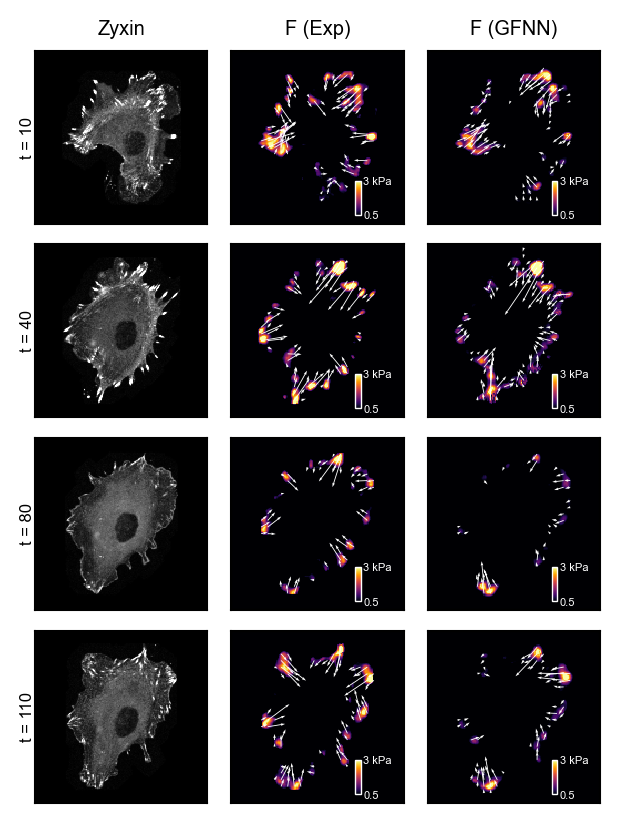

In [58]:
fig, ax = plt.subplots(4, 3, figsize=(3, 4), constrained_layout=True, dpi=200)

tidxs = [10, 40, 80, 110]
ax[0, 0].set_title('Zyxin')
ax[0, 1].set_title('F (Exp)')
ax[0, 2].set_title('F (GFNN)')
kwargs = dict(cmap='Greys_r', vmin=0, vmax=4)

for i, tidx in enumerate(tidxs):
    dataset.transform = gfnn_transform
    img_batch = dataset[tidx]
    numpy_transform = Compose(gfnn_transform.transforms[:3])
    dataset.transform = numpy_transform
    x = dataset[tidx]['zyxin'][0]

    ax[i, 0].set_ylabel('t = %d' % tidx)
    ax[i, 0].imshow(x[crop:-crop, crop:-crop], **kwargs)
    vector_plot(ax[i, 1], img_batch[1].cpu()[:, crop:-crop, crop:-crop])
    
    with torch.no_grad():
        y = gfnn_model(img_batch[0][None])[0]
        vector_plot(ax[i, 2], y.cpu()[:, crop:-crop, crop:-crop])
        
for a in ax.flatten():
    a.set(xticks=[], yticks=[])

## We don't need to include the $\nabla \phi$ terms

In [75]:
def residual(u, v):
    umag = torch.linalg.norm(u, dim=-3)
    vmag = torch.linalg.norm(v, dim=-3)
    uavg = torch.sqrt(umag.pow(2).mean(dim=(-2, -1), keepdims=True))
    vavg = torch.sqrt(vmag.pow(2).mean(dim=(-2, -1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - \
        2 * uavg * vavg * torch.einsum('...ijk,...ijk->...jk', u, v)
    res /= 2 * vavg**2 * uavg**2
    return res

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset.transform = gfnn_model.get_transform(**info['hparams'])
gfnn_model.to(device)
gfnn_model.eval()
with torch.no_grad():
    Fml, F1, F2, res = [], [], [], []
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16, 
                                         num_workers=0, 
                                         shuffle=False, 
                                         pin_memory=True)
    for batch in tqdm(loader):
        x, y0 = batch
        x = x.to(device)
        
        b, c, h, w = x.shape
        x = gfnn_model.conv_in(x)

        pad_size = [h + gfnn_model.pad, w + gfnn_model.pad]

        xq = torch.fft.rfft2(x, s=pad_size)
        xq = torch.einsum('jyx,bjyx->bjyx', gfnn_model.get_kernel(), xq)

        grad_phi = fft.irfft2(mtwopii * gfnn_model.q * xq[:, 0:1], s=pad_size)
        psi = fft.irfft2(xq[:, 1:2], s=pad_size)
        grad_chi = fft.irfft2(mtwopii * gfnn_model.q * xq[:, 2:3], s=pad_size)

        x1 = grad_phi + psi * grad_chi
        x1 = x1[..., :h, :w] #Crop away spoiled terms
        
        x2 = psi * grad_chi
        x2 = x2[..., :h, :w]
        
        res.append(residual(x1, x2).mean(dim=(-2, -1)).cpu().numpy())

        Fml.append(np.linalg.norm(y0.cpu().numpy(), axis=-3).sum(axis=(-2, -1)))
        F1.append(np.linalg.norm(x1.cpu().numpy(), axis=-3).sum(axis=(-2, -1)))  
        F2.append(np.linalg.norm(x2.cpu().numpy(), axis=-3).sum(axis=(-2, -1)))

100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Mean Residual:  0.011410576


Text(-0.42, 1.1, 'b')

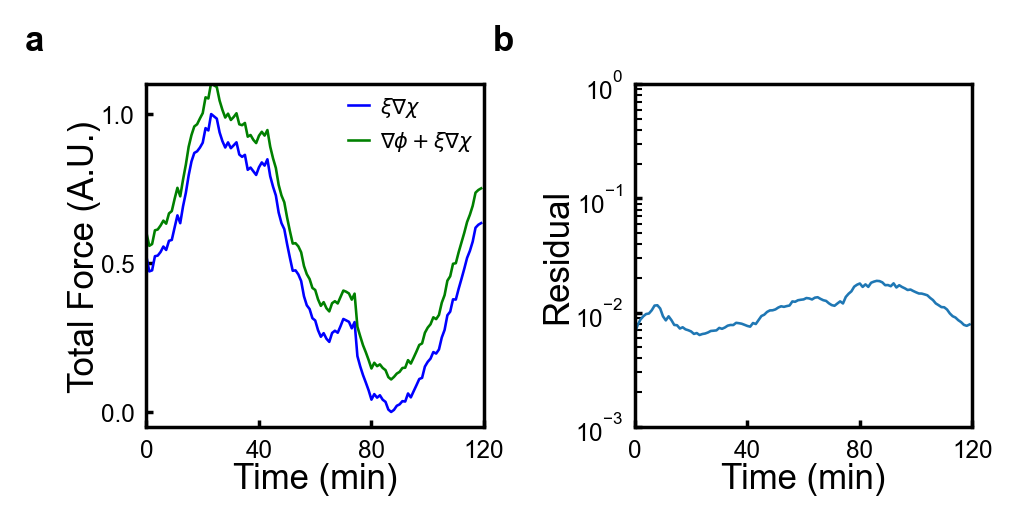

In [76]:
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.framealpha'] = 0.


fig, ax = plt.subplots(1, 2, dpi=250, sharex=True, figsize=(4, 2))
F_ml = np.concatenate(Fml)
F_1 = np.concatenate(F1)
F_2 = np.concatenate(F2)
Res = np.concatenate(res)
t = np.arange(Res.shape[0])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

ax[0].plot(t, scaler.fit_transform(F_2[:, None]), linestyle='-', color='blue', label=r'$\xi \nabla \chi$')
ax[0].plot(t, scaler.transform(F_1[:, None]), linestyle='-', color='green', label=r'$\nabla \phi + \xi \nabla \chi$')


ax[0].set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
ax[1].set(xlabel='Time (min)')
ax[0].set(ylim=[-0.05, 1.1], yticks=[0, 0.5, 1], ylabel='Total Force (A.U.)')
ax[0].legend(fontsize=6, handlelength=1)

ax[1].plot(t, Res)
ax[1].set_ylim([1e-3, 1])
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Residual')
print('Mean Residual: ', Res.mean())

plt.tight_layout()

ax[0].text(-0.36, 1.1, 'a', transform=ax[0].transAxes, fontweight='bold')
ax[1].text(-0.42,  1.1, 'b', transform=ax[1].transAxes, fontweight='bold')

#plt.savefig('SIFig_Clebsch.pdf', bbox_inches='tight', dpi=300)